In [6]:
import cv2
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt

# 載入圖片
image_path = "data/railroad/raw_data/annotated_railroad0_sat.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width = image.shape[:2]

# 定義旋轉角度
angle = -30

# 定義 albumentations 轉換
transform = A.Compose([
    A.Rotate(limit=(angle, angle), border_mode=cv2.BORDER_CONSTANT, value=[0, 0, 0], p=1.0)
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))



82 183
176 40
103 206


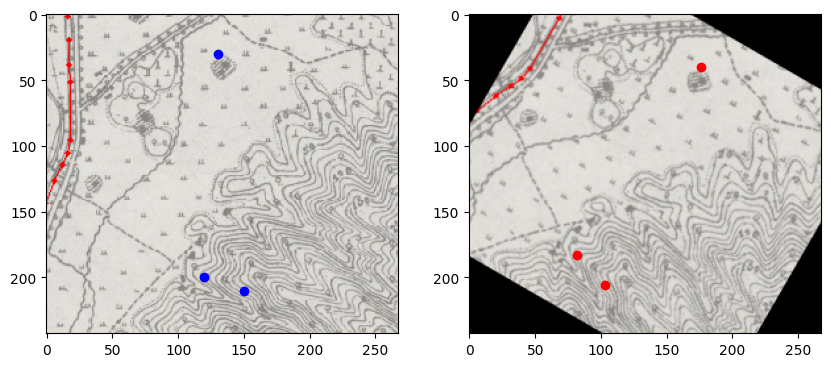

{(82, 183): [], (176, 40): [], (103, 206): []}

In [7]:
# 節點字典
node_dict = {
    (120, 200): [(150, 210)],
    (130, 30): [(150, 210)],
    (150, 210): [(120, 200), (130, 30)],
}

# 獲取節點座標
keypoints = list(node_dict.keys())

# 進行變換
transformed = transform(image=image, keypoints=keypoints)
transformed_image = transformed["image"]
transformed_keypoints = transformed["keypoints"]

# 轉換 keypoints 為整數格式
transformed_keypoints = [(int(x), int(y)) for x, y in transformed_keypoints]

# 過濾超出邊界的節點
new_node_dict = {}
for (orig_point, trans_point) in zip(keypoints, transformed_keypoints):
    x, y = trans_point
    
    if 0 <= x < width and 0 <= y < height:
        print(x, y)
        new_node_dict[trans_point] = [
            (int(nx), int(ny)) for nx, ny in node_dict[orig_point] if (int(nx), int(ny)) in transformed_keypoints 
        ]

# 繪製變換後的圖片和節點
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.scatter(*zip(*keypoints), c='blue', label="Original Nodes")

plt.subplot(1, 2, 2)
plt.imshow(transformed_image)
plt.scatter(*zip(*new_node_dict.keys()), c='red', label="Transformed Nodes")

plt.show()

# 顯示新的節點字典
new_node_dict


In [8]:
keypoints

[(120, 200), (130, 30), (150, 210)]

In [38]:
a = []
for k in node_dict.keys():
    conn = []
    for n in node_dict[k]:
        try:
            conn.append(keypoints.index(n))
        except:
            pass
    a.append(conn)
print(a)

[[2], [2], [0, 1]]


In [2]:
import pyvista
import numpy as np

In [11]:
import cv2
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

def random_hide_with_new_node(image, nodes, hide_ratio=0.3):
    """
    隨機遮擋地圖圖片，並在邊界新增節點
    Args:
        image (numpy array): 輸入圖片
        nodes (list of tuples): 節點座標 [(x0, y0), (x1, y1), ...]
        hide_ratio (float): 遮擋範圍的比例

    Returns:
        new_image (numpy array): 增強後的圖片
        new_nodes (list of tuples): 更新後的節點座標
    """
    H, W, _ = image.shape

    # 隨機選擇隨機遮擋範圍
    hide_top = random.randint(0, int(H * hide_ratio))

    # 在原圖上添加黑色遮擋區域
    new_image = image.copy()
    new_image[:hide_top, :] = 0  # 上方遮擋 (黑色區域)

    # 新節點計算
    new_nodes = []
    for i in range(len(nodes) - 1):
        x0, y0 = nodes[i]
        x1, y1 = nodes[i + 1]

        # 如果節點超出遮擋邊界，計算新節點
        if y0 < hide_top and y1 > hide_top:
            # 線性插值計算新節點
            ratio = (hide_top - y0) / (y1 - y0)
            new_x = int(x0 + ratio * (x1 - x0))
            new_y = hide_top
            new_nodes.append((new_x, new_y))  # 新增新節點 (紅點)
        
        # 保留所有原始節點
        if y0 > hide_top:
            new_nodes.append((x0, y0))

    return new_image, new_nodes

# 測試資料
image = cv2.imread('data/railroad/raw_data/annotated_railroad0_sat.png')  # 載入圖片
nodes = [(50, 50), (100, 40), (20, 120), (200, 200)]





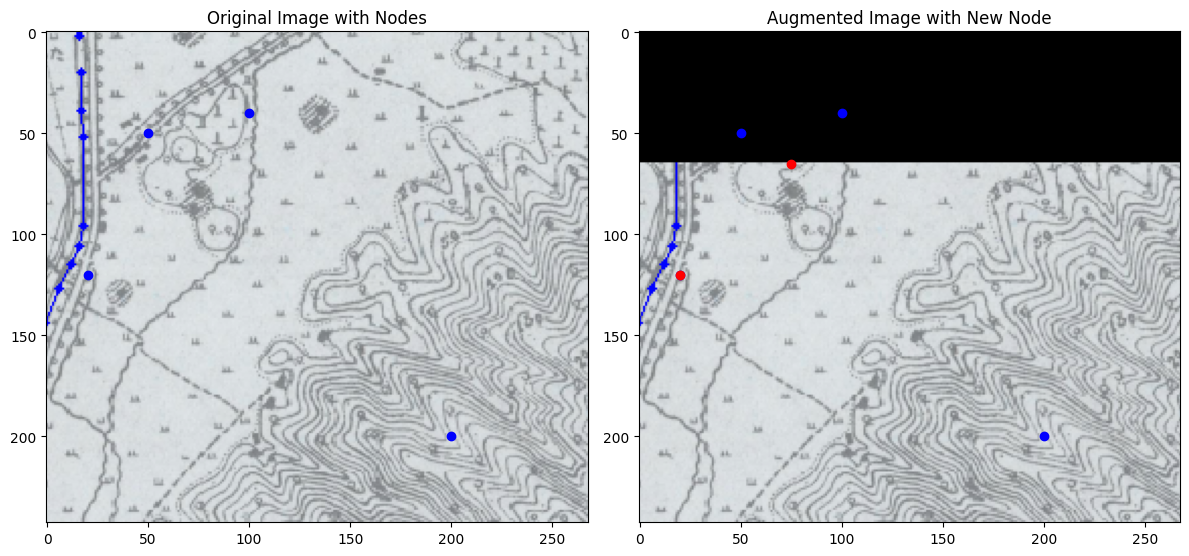

In [12]:
# 執行增強
new_image, new_nodes = random_hide_with_new_node(image.copy(), nodes)

# 視覺化原始影像與增強後影像
plt.figure(figsize=(12, 6))

# 原始影像
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image with Nodes")
plt.scatter(*zip(*nodes), color='blue', label='Original Nodes')

# 增強後影像
plt.subplot(1, 2, 2)
plt.imshow(new_image)
plt.title("Augmented Image with New Node")
plt.scatter(*zip(*nodes), color='blue', label='Original Nodes')
plt.scatter(*zip(*new_nodes), color='red', label='New Node')

plt.tight_layout()
plt.show()

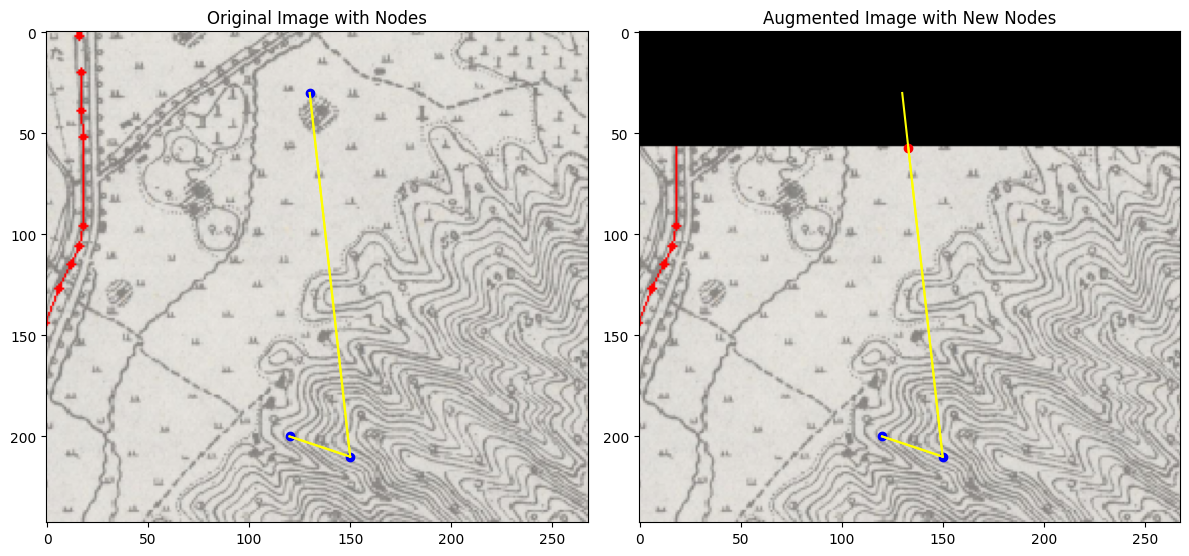

In [19]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

def random_hide_with_new_node(image, node_dict, hide_ratio=0.3):
    """
    隨機遮擋地圖圖片，並在邊界新增節點
    Args:
        image (numpy array): 輸入圖片
        node_dict (dict): 節點資料 {節點: [相連節點]}
        hide_ratio (float): 遮擋範圍的比例

    Returns:
        new_image (numpy array): 增強後的圖片
        new_node_dict (dict): 更新後的節點資料
    """
    H, W, _ = image.shape

    # 隨機選擇遮擋邊界 (隨機選擇上方遮擋)
    hide_top = random.randint(0, int(H * hide_ratio))

    # 在圖片上新增黑色遮擋區域
    new_image = image.copy()
    new_image[:hide_top, :] = 0  # 上方遮擋 (黑色區域)

    # 新節點資料結構
    new_node_dict = {}

    # 遍歷每個節點及其連接的節點
    for node, connected_nodes in node_dict.items():
        x0, y0 = node
        new_node_dict[node] = []  # 初始化新字典

        for x1, y1 in connected_nodes:
            # 如果一個點在遮擋區域內，而另一個在外部，計算新節點
            if (y0 < hide_top and y1 > hide_top) or (y1 < hide_top and y0 > hide_top):
                # 線性插值計算新節點
                ratio = (hide_top - y0) / (y1 - y0)
                new_x = int(x0 + ratio * (x1 - x0))
                new_y = hide_top
                
                # 新節點
                new_node = (new_x, new_y)
                new_node_dict[new_node] = [node, (x1, y1)]

                # 更新原始節點的連接資訊
                new_node_dict[node].append(new_node)

            # 保留原始連接節點 (未超出遮擋區域的情況)
            if y0 > hide_top:
                new_node_dict[node].append((x1, y1))

    return new_image, new_node_dict

# 測試資料
image = cv2.imread('data/railroad/raw_data/annotated_railroad0_sat.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 節點資料
node_dict = {
    (120, 200): [(150, 210)],
    (130, 30): [(150, 210)],
    (150, 210): [(120, 200), (130, 30)],
    (200, 150): [(10, 30)],
    (10, 30): [(200, 150), (100, 200)],
    (100, 200): [(10, 30
}

# 執行增強
new_image, new_node_dict = random_hide_with_new_node(image.copy(), node_dict)

# 視覺化結果
plt.figure(figsize=(12, 6))

# 原始影像
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image with Nodes")
for node, connected_nodes in node_dict.items():
    plt.scatter(*node, color='blue')
    for connected_node in connected_nodes:
        plt.plot([node[0], connected_node[0]], [node[1], connected_node[1]], 'yellow')

# 增強後影像
plt.subplot(1, 2, 2)
plt.imshow(new_image)
plt.title("Augmented Image with New Nodes")
for node, connected_nodes in new_node_dict.items():
    plt.scatter(*node, color='blue')
    for connected_node in connected_nodes:
        color = 'red' if connected_node not in node_dict else 'yellow'
        plt.plot([node[0], connected_node[0]], [node[1], connected_node[1]], color)

plt.tight_layout()
plt.show()


In [18]:
new_node_dict

{(120, 200): [(150, 210)],
 (130, 30): [(133, 60)],
 (133, 60): [(150, 210), (130, 30)],
 (150, 210): [(120, 200), (133, 60), (130, 30)],
 (200, 150): [(57, 60), (10, 30)],
 (57, 60): [(10, 30), (200, 150)],
 (10, 30): [(57, 60), (25, 60)],
 (25, 60): [(100, 200), (10, 30)],
 (100, 200): [(25, 60), (10, 30)]}

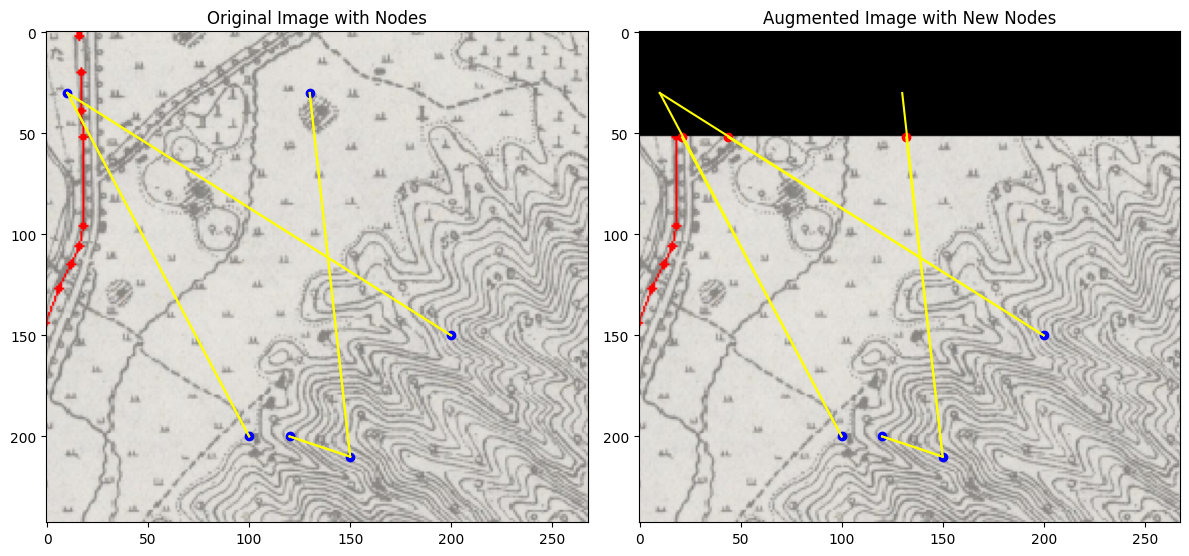

In [23]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

def random_hide_with_new_node(image, node_dict, hide_ratio=0.3):
    """
    隨機遮擋地圖圖片，並在邊界新增節點，替代被遮擋的節點。
    Args:
        image (numpy array): 輸入圖片
        node_dict (dict): 節點資料 {節點: [相連節點]}
        hide_ratio (float): 遮擋範圍的比例

    Returns:
        new_image (numpy array): 增強後的圖片
        new_node_dict (dict): 更新後的節點資料
    """
    H, W, _ = image.shape

    # 隨機選擇遮擋邊界 (隨機選擇上方遮擋)
    hide_top = random.randint(0, int(H * hide_ratio))

    # 在圖片上新增黑色遮擋區域
    new_image = image.copy()
    new_image[:hide_top, :] = 0  # 上方遮擋 (黑色區域)

    # 新節點資料結構
    new_node_dict = {}

    # 遍歷每個節點及其連接的節點
    for node, connected_nodes in node_dict.items():
        x0, y0 = node

        for x1, y1 in connected_nodes:
            # 如果一個點在遮擋區域內，而另一個在外部，計算新節點
            if (y0 < hide_top and y1 > hide_top) or (y1 < hide_top and y0 > hide_top):
                # 線性插值計算新節點
                ratio = (hide_top - y0) / (y1 - y0)
                new_x = int(x0 + ratio * (x1 - x0))
                new_y = hide_top
                
                # 新增的新節點
                new_node = (new_x, new_y)
                
                # 更新新節點資料
                new_node_dict[new_node] = [node if y0 > hide_top else (x1, y1)]

            # 若節點未被遮擋，則保留
            if y0 > hide_top:
                if node not in new_node_dict:
                    new_node_dict[node] = []
                new_node_dict[node].append((x1, y1))

    return new_image, new_node_dict

# 測試資料
image = cv2.imread('data/railroad/raw_data/annotated_railroad0_sat.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 節點資料
node_dict = {
    (120, 200): [(150, 210)],
    (130, 30): [(150, 210)],
    (150, 210): [(120, 200), (130, 30)],
    (200, 150): [(10, 30)],
    (10, 30): [(200, 150), (100, 200)],
    (100, 200): [(10, 30)]
}

# 執行增強
new_image, new_node_dict = random_hide_with_new_node(image.copy(), node_dict)

# 視覺化結果
plt.figure(figsize=(12, 6))

# 原始影像
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image with Nodes")
for node, connected_nodes in node_dict.items():
    plt.scatter(*node, color='blue')
    for connected_node in connected_nodes:
        plt.plot([node[0], connected_node[0]], [node[1], connected_node[1]], 'yellow')

# 增強後影像
plt.subplot(1, 2, 2)
plt.imshow(new_image)
plt.title("Augmented Image with New Nodes")
for node, connected_nodes in new_node_dict.items():
    plt.scatter(*node, color='blue' if node in node_dict else 'red')
    for connected_node in connected_nodes:
        plt.plot([node[0], connected_node[0]], [node[1], connected_node[1]], 'yellow')

plt.tight_layout()
plt.show()


In [28]:
random.randint(0, int(259 * 0.3))

25